## goal of this notebook
 - Familiarize with tf estimator API
 - Play with airbnb open data for amsterdam

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
used_features = ['property_type','room_type','bathrooms','bedrooms','beds','bed_type','accommodates','host_total_listings_count'
                ,'number_of_reviews','review_scores_value','neighbourhood_cleansed','cleaning_fee','minimum_nights','security_deposit','host_is_superhost',
                 'instant_bookable', 'price']

amsterdam = pd.read_csv('data/amsterdam-listings.csv', usecols = used_features)
amsterdam.info()
amsterdam.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20114 entries, 0 to 20113
Data columns (total 17 columns):
host_is_superhost            20109 non-null object
host_total_listings_count    20109 non-null float64
neighbourhood_cleansed       20114 non-null object
property_type                20114 non-null object
room_type                    20114 non-null object
accommodates                 20114 non-null int64
bathrooms                    20105 non-null float64
bedrooms                     20107 non-null float64
beds                         20108 non-null float64
bed_type                     20114 non-null object
price                        20114 non-null object
security_deposit             13802 non-null object
cleaning_fee                 16490 non-null object
minimum_nights               20114 non-null int64
number_of_reviews            20114 non-null int64
review_scores_value          17371 non-null float64
instant_bookable             20114 non-null object
dtypes: float64(5), in

,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,minimum_nights,number_of_reviews,review_scores_value,instant_bookable
0,t,1.0,Oostelijk Havengebied - Indische Buurt,Apartment,Private room,2,1.5,1.0,2.0,Real Bed,$69.00,$100.00,$40.00,3,237,10.0,t
1,f,1.0,Westerpark,Apartment,Entire home/apt,5,1.0,2.0,2.0,Real Bed,$160.00,$300.00,$40.00,2,40,9.0,f
2,f,2.0,Centrum-Oost,Townhouse,Private room,2,1.0,1.0,1.0,Real Bed,$80.00,NaN,NaN,1,215,9.0,f
3,f,2.0,Centrum-West,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,$125.00,$300.00,$40.00,14,1,10.0,f
4,t,1.0,Centrum-West,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,$150.00,$0.00,$0.00,2,154,10.0,t


In [3]:
dollar_columns = ["cleaning_fee","security_deposit","price"]
# clearning the dollar sign and string to float, and fill the na with median value of that column
for feature in dollar_columns:
    amsterdam[feature] = amsterdam[feature].map(lambda x:x.replace("$",'').replace(",",''),na_action = 'ignore')
    amsterdam[feature] = amsterdam[feature].astype(float)
    amsterdam[feature].fillna(amsterdam[feature].median(),inplace = True)

In [4]:
# convert t to 0, f to 1
binary_columns = ["host_is_superhost", "instant_bookable"]
for feature in binary_columns:
    amsterdam[feature] = amsterdam[feature].map(lambda x: x=="t",na_action = 'ignore')
    amsterdam[feature] = amsterdam[feature].fillna(0)
    amsterdam[feature] = amsterdam[feature].astype(int)

In [5]:
amsterdam["price"].sort_values(ascending=False)
amsterdam.loc[131]

host_is_superhost                                  0
host_total_listings_count                          1
neighbourhood_cleansed       De Pijp - Rivierenbuurt
property_type                              Apartment
room_type                            Entire home/apt
accommodates                                       4
bathrooms                                          1
bedrooms                                           1
beds                                               1
bed_type                                    Real Bed
price                                           8000
security_deposit                                  80
cleaning_fee                                      15
minimum_nights                                    30
number_of_reviews                                  8
review_scores_value                                8
instant_bookable                                   0
Name: 131, dtype: object

In [6]:
# fillna for the numerical values
for feature in ["bathrooms","bedrooms","beds","review_scores_value", "host_total_listings_count"]:
    amsterdam[feature].fillna(amsterdam[feature].median(),inplace = True)
    
amsterdam['property_type'].fillna('Apartment',inplace = True)

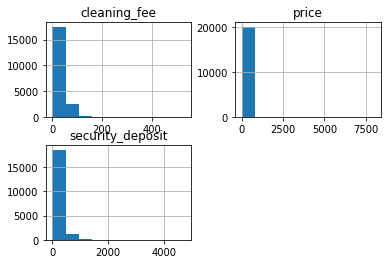

In [7]:
ax = amsterdam[dollar_columns].hist(grid = True)
plt.title("Price histogram before subsetting and log-transformation");

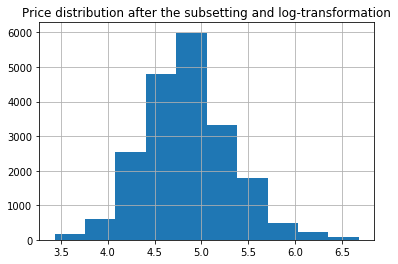

In [8]:
# the price is has a positive long tail since skew is huge
amsterdam = amsterdam[(amsterdam["price"]>30)&(amsterdam["price"]<800)]
logged_target = np.log(amsterdam["price"])
logged_target.hist()
plt.title("Price distribution after the subsetting and log-transformation");

In [9]:
features = amsterdam.drop('price',axis=1)
features.head()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     features, logged_target, test_size=0.33, random_state=42)

In [10]:
# Get all the numeric feature names
numeric_columns = ['host_total_listings_count','accommodates','bathrooms','bedrooms','beds',
 'security_deposit','cleaning_fee','minimum_nights','number_of_reviews',
 'review_scores_value']
# Get all the categorical feature names that contains strings
categorical_columns = ['host_is_superhost','neighbourhood_cleansed','property_type','room_type','bed_type','instant_bookable']

numeric_features = [tf.feature_column.numeric_column(key = col) for col in numeric_columns]

In [11]:
categorical_features = [tf.feature_column.categorical_column_with_vocabulary_list(key = x,
                                                                          vocabulary_list = amsterdam[x].value_counts().keys()
                                                                          ) for x in categorical_columns]

In [12]:
linear_features = numeric_features + categorical_features

In [13]:
# Create training input function
training_input_fn = tf.estimator.inputs.pandas_input_fn(x = X_train,
                                                        y=y_train,
                                                        batch_size=32,
                                                        shuffle= True,
                                                        num_epochs = None)
# create testing input function
eval_input_fn = tf.estimator.inputs.pandas_input_fn(x=X_test,
                                                    y=y_test,
                                                    batch_size=32,
                                                    shuffle=False,
                                                    num_epochs = 1)

In [14]:
linear_regressor = tf.estimator.LinearRegressor(feature_columns=linear_features,
                                                model_dir = "linear_regressor")
linear_regressor.train(input_fn = training_input_fn,steps=2000)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'linear_regressor', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a22cb2a90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from linear_regressor/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpo

In [15]:
linear_regressor.evaluate(input_fn = eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-16-22:14:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from linear_regressor/model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-08-16-22:14:15
INFO:tensorflow:Saving dict for global step 4000: average_loss = 0.12767285, global_step = 4000, loss = 4.0719624


{'average_loss': 0.12767285, 'global_step': 4000, 'loss': 4.0719624}

In [16]:
pred = list(linear_regressor.predict(input_fn = eval_input_fn))
pred = [p['predictions'][0] for p in pred]
prices = np.exp(pred)
print(prices)
linear_regressor.get_variable_value('linear/linear_model/neighbourhood_cleansed/weights')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from linear_regressor/model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[ 96.76826  199.31635  167.77414  ... 122.042625 116.24911   57.821747]


array([[ 0.36881417],
       [ 0.39319193],
       [ 0.5925674 ],
       [ 0.54712933],
       [ 0.36891752],
       [ 0.36830422],
       [ 0.3117167 ],
       [ 0.24137065],
       [ 0.25905332],
       [ 0.24081376],
       [ 0.19947346],
       [ 0.17978892],
       [ 0.1639481 ],
       [ 0.11061545],
       [ 0.05687611],
       [ 0.25237444],
       [ 0.17048584],
       [ 0.10985601],
       [ 0.19042799],
       [ 0.06419258],
       [ 0.06835458],
       [-0.01899394]], dtype=float32)

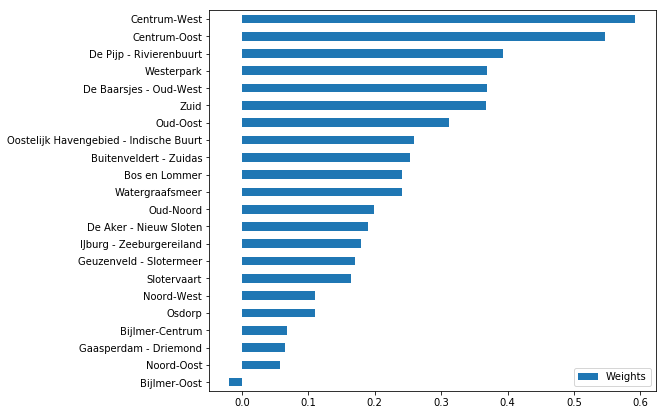

In [17]:
property_weights = linear_regressor.get_variable_value('linear/linear_model/neighbourhood_cleansed/weights').flatten()
property_keys = amsterdam["neighbourhood_cleansed"].value_counts().keys()
pd.DataFrame({"Weights":property_weights},index=property_keys).sort_values("Weights",ascending=True).plot(kind="barh", 
                                                                                                          figsize= (8,7), 
                                                                                                          grid = False
                                                                                                         )

the above plot also confirm with the niceness level of these neighborhoods